# CSPB 3022 PROJECT  

Xuehan Cheng

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

import patsy
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.neighbors as neighbors
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import sklearn.tree

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## 1.Introduction

### Purpose

This project is in order to check what factors are important when apply for a master program and to predict whether an international student has capacity to be admitted into a good graduate school. Students can figure out what they need to prepare for applicaiton.

### Data Source

I found this dataset which is called Graduate Admission2 on Kaggle. 
https://www.kaggle.com/mohansacharya/graduate-admissions  
Graduate Admssion2 dataset is created for prediction of graduate admission. It has several important factors which would be taken into considerations during the application for Master Programs.  

## 2. Contents of the Dataset

### Overview of the Dataset  
Using the head funciton to get the first five rows of the dataframe

In [312]:
df= pd.read_csv("Admission_Predict_Ver1.1.csv")

In [313]:
df.head(5)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


The graduate admission dataset includes the following 8 variables listed below:   

Parameters/factors/features:  
continuous numerical:  
GRE Scores (290 to 340): Graduate Record Examination  
TOEFL Scores (92 to 120): Test of English as a Foreign Language  
Undergraduate CGPA (6.8 to 9.92) : Culmulative Grade Point Average  

categorical:  
University Rating (1 to 5): a student's University rating, the higher number the higher the rating  
Statement of Purpose (1 to 5)  
Letter of Recommendation Strength (1 to 5)  
Research Experience (0 or 1) : whether a student had a history of publishing paper.  
  
continuous numerical:  
Response variable:   
Chance of Admit (0.34 to 0.97)  

### Clean the Data

The Serial No. column is unnecessary because it is the index of the data, so I removed this column. The response variable in the dataset is the Chance of Admit. Thus, I changed its position to the first column. The remaining columns are the factors/features of the dataset.

In [314]:
admit=df.drop(labels='Serial No.',axis=1)

In [315]:
admit.dropna()
admit=admit.rename(columns={"GRE Score": "GRE", "TOEFL Score":"TOEFL","University Rating":"URating","Chance of Admit ":"Chance","LOR ":"LOR"});
admit=admit[['Chance','GRE','TOEFL','SOP','LOR','CGPA','Research','URating']]
admit['CGPA']=admit['CGPA']/(2.5)
admit.head()

,Chance,GRE,TOEFL,SOP,LOR,CGPA,Research,URating
0,0.92,337,118,4.5,4.5,3.860,1,4
1,0.76,324,107,4.0,4.5,3.548,1,4
2,0.72,316,104,3.0,3.5,3.200,1,3
3,0.80,322,110,3.5,2.5,3.468,1,3
4,0.65,314,103,2.0,3.0,3.284,0,2


Because outliers will dramatically affect the result of prediction

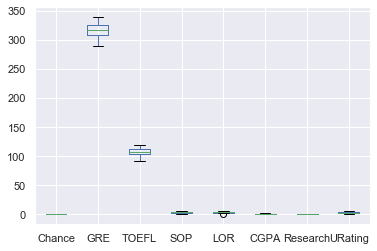

In [257]:
 boxplot = admit.boxplot(column=['Chance','GRE','TOEFL','SOP','LOR','CGPA','Research','URating'])

It's hard to get information from the boxplot above. Because the ranges of the data are different. We need normalize them.

In [258]:
admit2=pd.DataFrame()
admit2['Chance']=admit['Chance']
admit2['GRE']=admit['GRE']/340
admit2['TOEFL']=admit['TOEFL']/120
admit2['SOP']=admit['SOP']/5
admit2['LOR']=admit['LOR']/5
admit2['CGPA']=admit['CGPA']/4
admit2['Research']=admit['Research']
admit2['URating']=admit['URating']/5
admit2.head()

,Chance,GRE,TOEFL,SOP,LOR,CGPA,Research,URating
0,0.92,0.991176,0.983333,0.9,0.9,0.3860,1.0,0.8
1,0.76,0.952941,0.891667,0.8,0.9,0.3548,1.0,0.8
2,0.72,0.929412,0.866667,0.6,0.7,0.3200,1.0,0.6
3,0.80,0.947059,0.916667,0.7,0.5,0.3468,1.0,0.6
4,0.65,0.923529,0.858333,0.4,0.6,0.3284,0.0,0.4


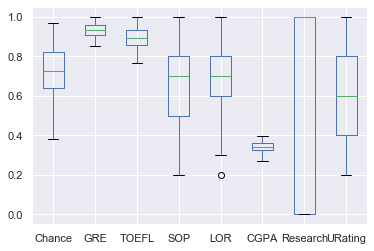

In [259]:
boxplot = admit2.boxplot(column=['Chance','GRE','TOEFL','SOP','LOR','CGPA','Research','URating'])

In [260]:
#input: the target dataframe 
def remove_outlier(df,features):
    #the numober of features in the dataframe
    length=df.shape[1]
    #a list of indices that have outliers
    idx=[]
    for feature in features:
        quartile1=np.percentile(df[feature],25)
        quartile3=np.percentile(df[feature],75)
        IQR=quartile3-quartile1
        outlier_range=1.5*IQR
        index=df[(df[feature]< quartile1-outlier_range) | (df[feature]>quartile3+outlier_range)].index
        df.loc[index,feature]=np.mean(df[feature]) 

In [316]:
remove_outlier(admit,['Chance','GRE', 'TOEFL','URating', 'SOP','CGPA', 'Research'])
remove_outlier(admit2,['Chance','GRE', 'TOEFL','URating', 'SOP','CGPA', 'Research'])

In [317]:
admit.head()

,Chance,GRE,TOEFL,SOP,LOR,CGPA,Research,URating
0,0.92,337.0,118.0,4.5,4.5,3.860,1.0,4.0
1,0.76,324.0,107.0,4.0,4.5,3.548,1.0,4.0
2,0.72,316.0,104.0,3.0,3.5,3.200,1.0,3.0
3,0.80,322.0,110.0,3.5,2.5,3.468,1.0,3.0
4,0.65,314.0,103.0,2.0,3.0,3.284,0.0,2.0


In [318]:
admit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
Chance      500 non-null float64
GRE         500 non-null float64
TOEFL       500 non-null float64
SOP         500 non-null float64
LOR         500 non-null float64
CGPA        500 non-null float64
Research    500 non-null float64
URating     500 non-null float64
dtypes: float64(8)
memory usage: 31.4 KB


In [319]:
admit.describe()

,Chance,GRE,TOEFL,SOP,LOR,CGPA,Research,URating
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,0.723267,316.472000,107.192000,3.374000,3.48400,3.430576,0.560000,3.114000
std,0.139048,11.295148,6.081868,0.991004,0.92545,0.241925,0.496884,1.143512
min,0.360000,290.000000,92.000000,1.000000,1.00000,2.720000,0.000000,1.000000
25%,0.637500,308.000000,103.000000,2.500000,3.00000,3.251000,0.000000,2.000000
50%,0.720870,317.000000,107.000000,3.500000,3.50000,3.424000,1.000000,3.000000
75%,0.820000,325.000000,112.000000,4.000000,4.00000,3.616000,1.000000,4.000000
max,0.970000,340.000000,120.000000,5.000000,5.00000,3.968000,1.000000,5.000000


## 3. Variable Exploration

### Pair Plot

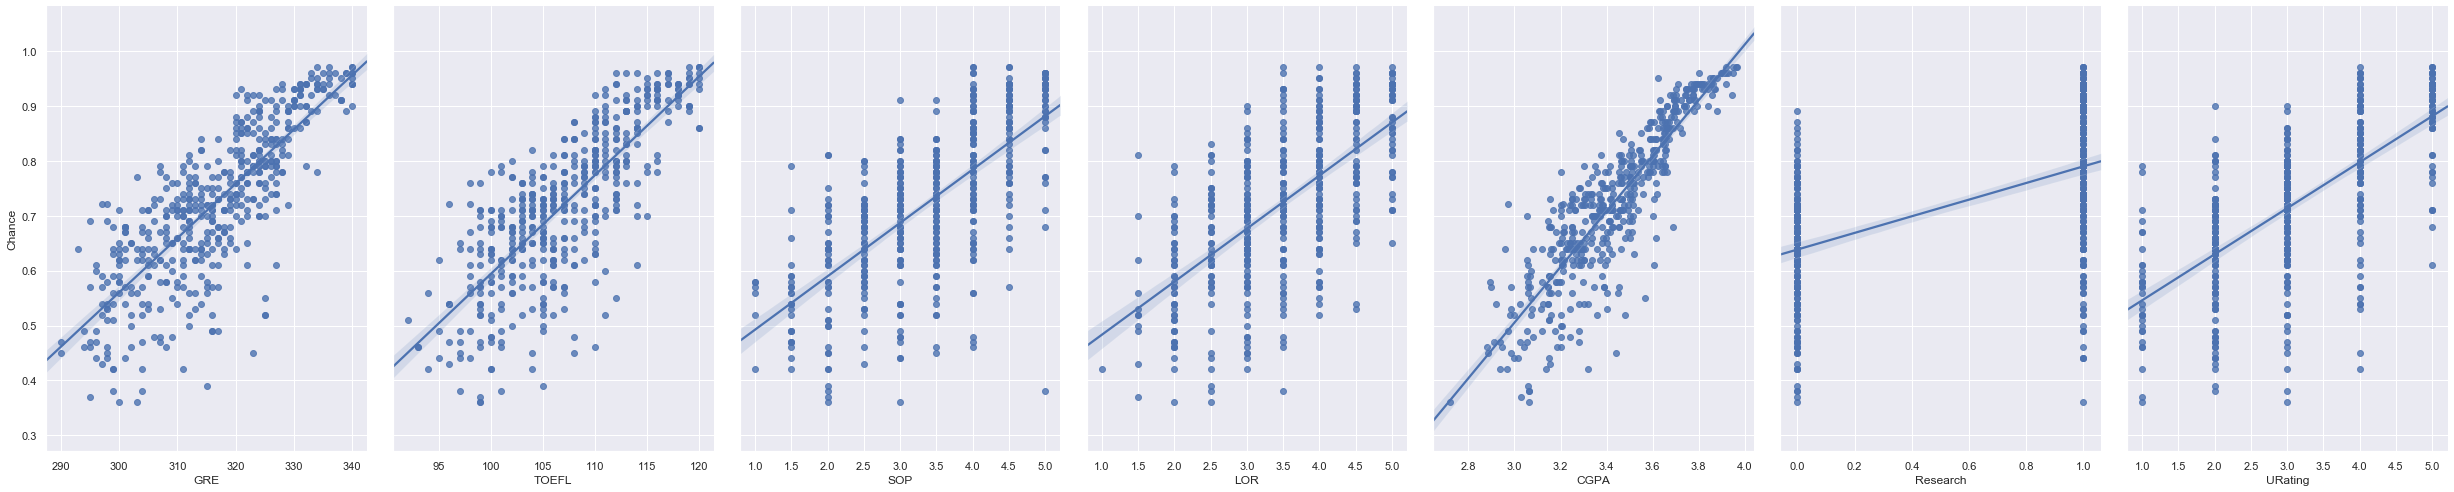

In [320]:
sns.pairplot(admit, x_vars=['GRE','TOEFL','SOP','LOR','CGPA','Research','URating'], 
             y_vars='Chance', height=7, aspect=0.7, kind='reg')

### Response variable: Chance to be admitted

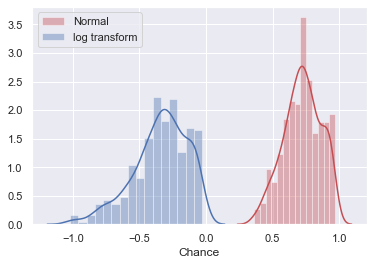

In [321]:
Chance=admit['Chance']
sns.distplot(Chance,color='r',label="Normal");
sns.distplot(np.log(Chance),color='b',label="log transform");
plt.legend();

It seems there is no need to do the data transformation.

Quick look of the entries with high admission chance

In [322]:
admit['HC']=admit['Chance'].apply(lambda x: 1 if x>= np.percentile(admit['Chance'],85) else 0)
admit2['HC']=admit2['Chance'].apply(lambda x: 1 if x>= np.percentile(admit2['Chance'],85) else 0)
np.percentile(admit2['Chance'],85)

0.89

In [323]:
high_chance=admit[admit['HC']==1]
high_chance.head()

,Chance,GRE,TOEFL,SOP,LOR,CGPA,Research,URating,HC
0,0.92,337.0,118.0,4.5,4.5,3.860,1.0,4.0,1
5,0.90,330.0,115.0,4.5,3.0,3.736,1.0,5.0,1
22,0.94,328.0,116.0,5.0,5.0,3.800,1.0,5.0,1
23,0.95,334.0,119.0,5.0,4.5,3.880,1.0,5.0,1
24,0.97,336.0,119.0,4.0,3.5,3.920,1.0,5.0,1


   ### Numeric Features

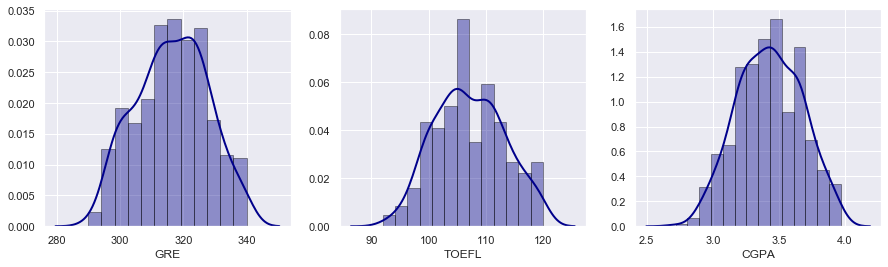

In [324]:
plt.figure(figsize=(15,4))
#fig, axes = plt.subplots(1, 3)
n_col=[admit['GRE'],admit['TOEFL'],admit['CGPA']]
i=0
for item in n_col:
    i=i+1
    plt.subplot(1, 3, i)
    sns.distplot(item, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.show()

#### GRE

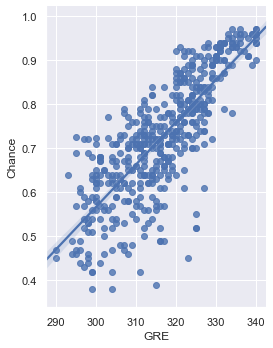

In [276]:
sns.pairplot(admit, x_vars=["GRE"], y_vars=["Chance"],
             height=5, aspect=.8, kind="reg");

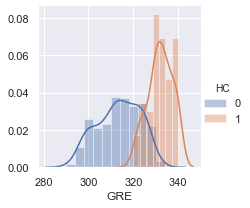

In [277]:
gre=sns.FacetGrid(admit,hue='HC')
gre=gre.map(sns.distplot,'GRE')
gre=gre.add_legend()

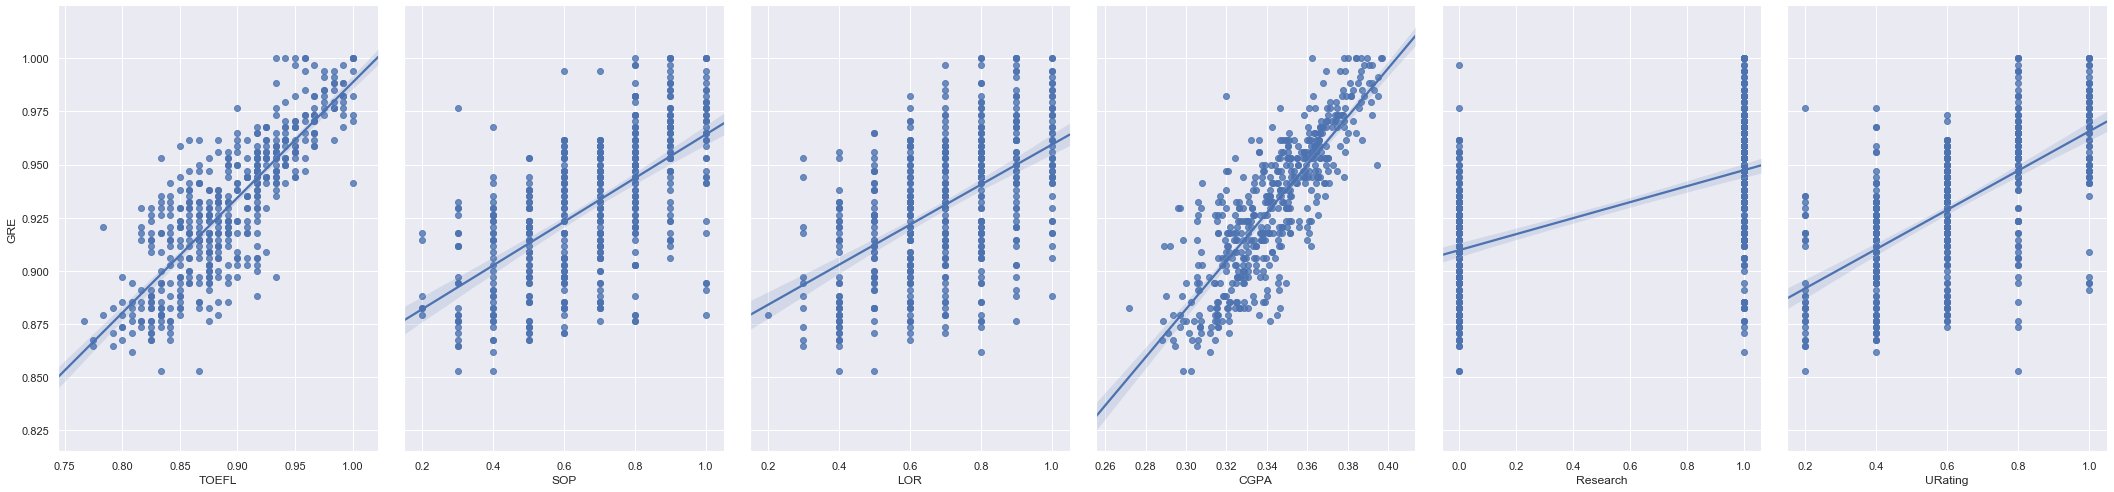

In [280]:
sns.pairplot(admit2, x_vars=['TOEFL','SOP','LOR','CGPA','Research','URating'], 
             y_vars='GRE', size=7, aspect=0.7,kind='reg')

#### TOEFL

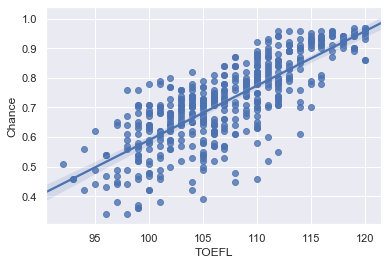

In [20]:
 sns.regplot(x=admit.TOEFL,y=admit.Chance,ci=99);

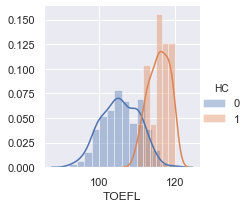

In [21]:
toefl=sns.FacetGrid(admit,hue='HC')
toefl=toefl.map(sns.distplot,'TOEFL')
toefl=toefl.add_legend()

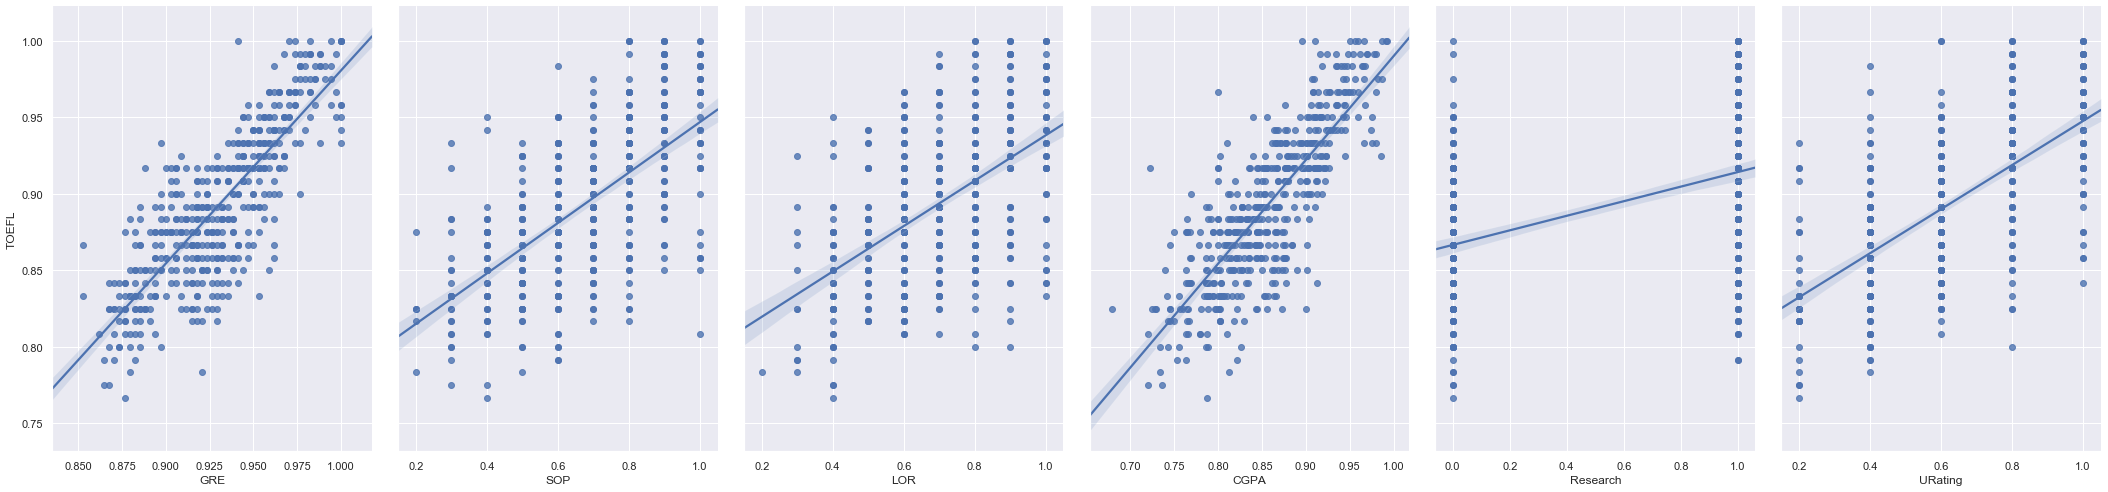

In [246]:
sns.pairplot(admit2, x_vars=['GRE','SOP','LOR','CGPA','Research','URating'], 
             y_vars='TOEFL', size=7, aspect=0.7, kind='reg')

#### CGPA

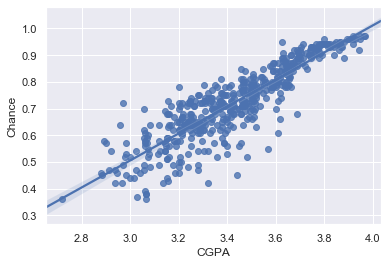

In [325]:
 sns.regplot(x=admit.CGPA,y=admit.Chance,ci=99);

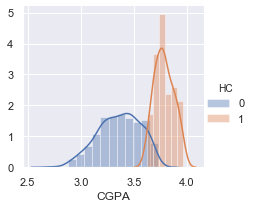

In [326]:
gpa=sns.FacetGrid(admit,hue='HC')
gpa=gpa.map(sns.distplot,'CGPA')
gpa=gpa.add_legend()

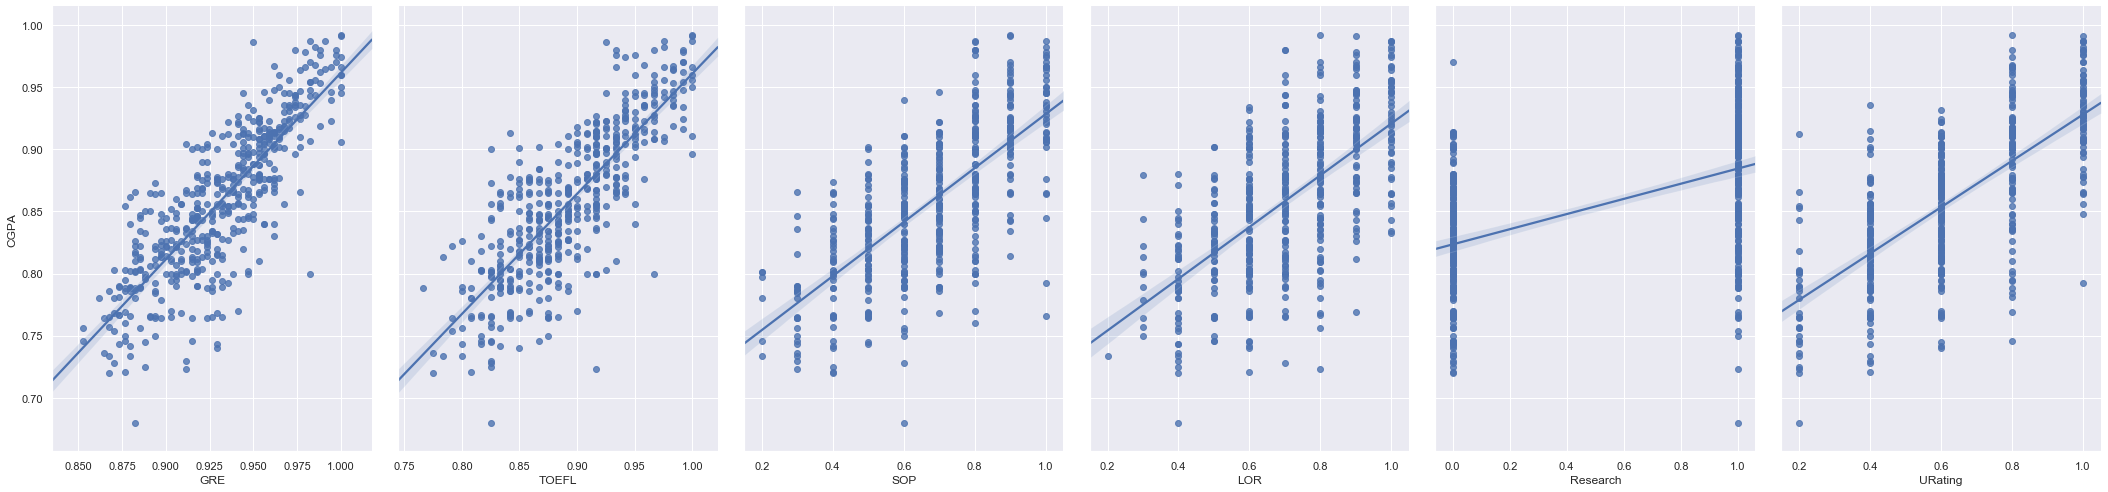

In [252]:
sns.pairplot(admit2, x_vars=['GRE','TOEFL','SOP','LOR','Research','URating'], 
             y_vars='CGPA', size=7, aspect=0.7, kind='reg')

### Categorical Features

The overview of the categorical features.

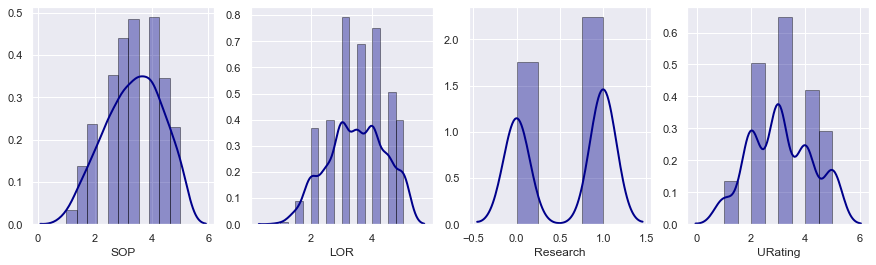

In [195]:
plt.figure(figsize=(15,4))
#fig, axes = plt.subplots(1, 3)
c_col=[admit['SOP'],admit['LOR'],admit['Research'],admit['URating']]
i=0
for item in c_col:
    i=i+1
    plt.subplot(1, 4, i)
    sns.distplot(item, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.show()

#### SOP

Distribution of the score of SOP

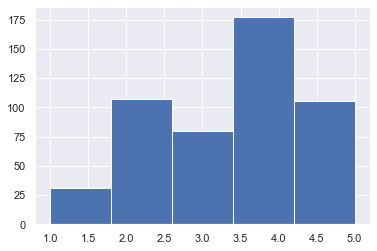

In [24]:
plt.hist(df.SOP, bins=5);

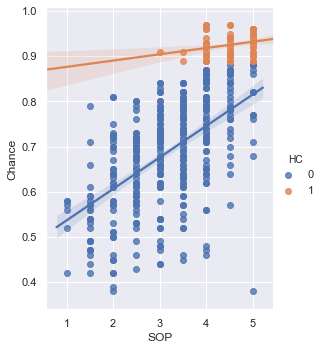

In [284]:
sns.pairplot(admit, x_vars=["SOP"], y_vars=["Chance"],
             hue="HC", height=5, aspect=.8, kind="reg");

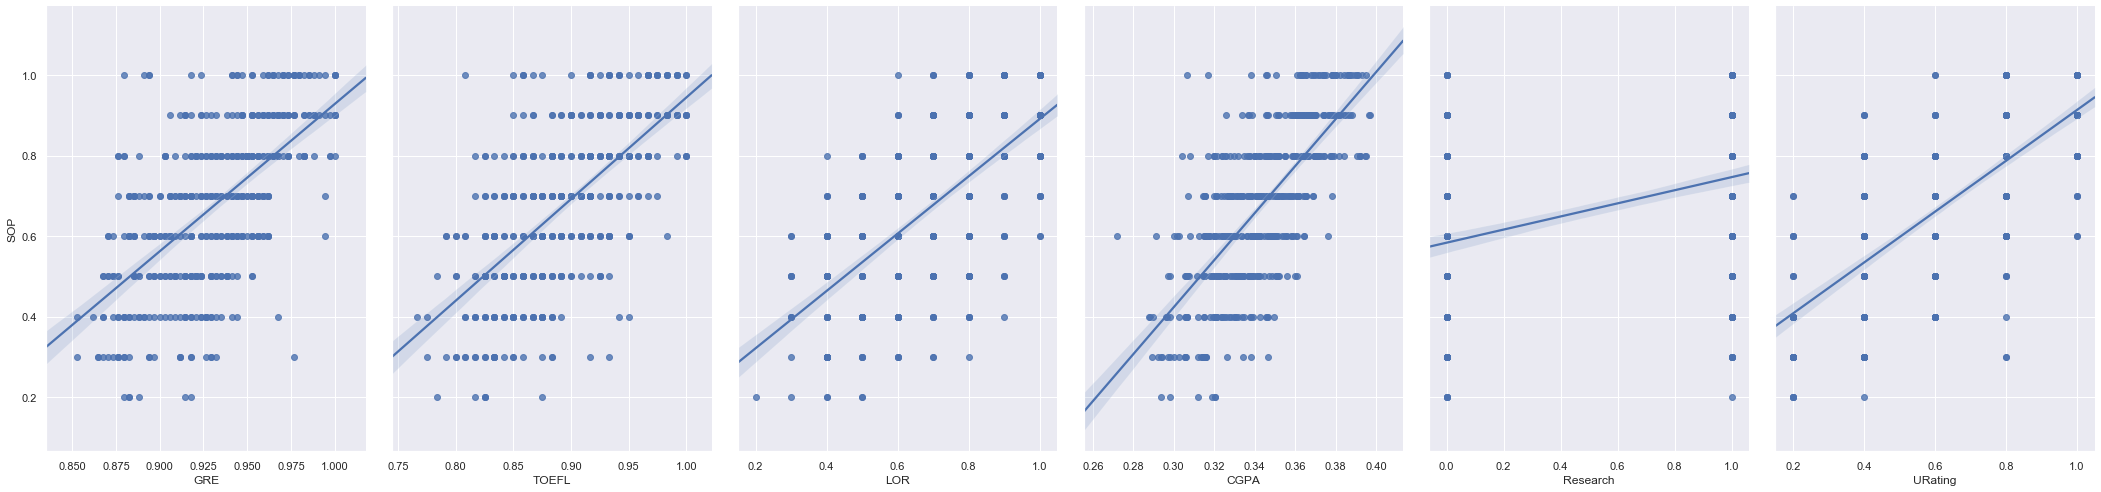

In [283]:
sns.pairplot(admit2, x_vars=['GRE','TOEFL','LOR','CGPA','Research','URating'], 
             y_vars='SOP', size=7, aspect=0.7, kind='reg')

#### LOR

distribution of the number of recommendation letters

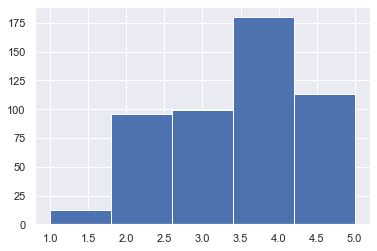

In [26]:
plt.hist(admit.LOR, bins=5);

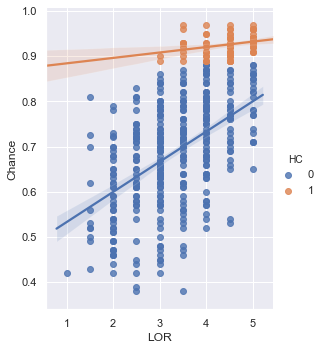

In [226]:
sns.pairplot(admit, x_vars=["LOR"], y_vars=["Chance"],
             hue="HC", height=5, aspect=.8, kind="reg");

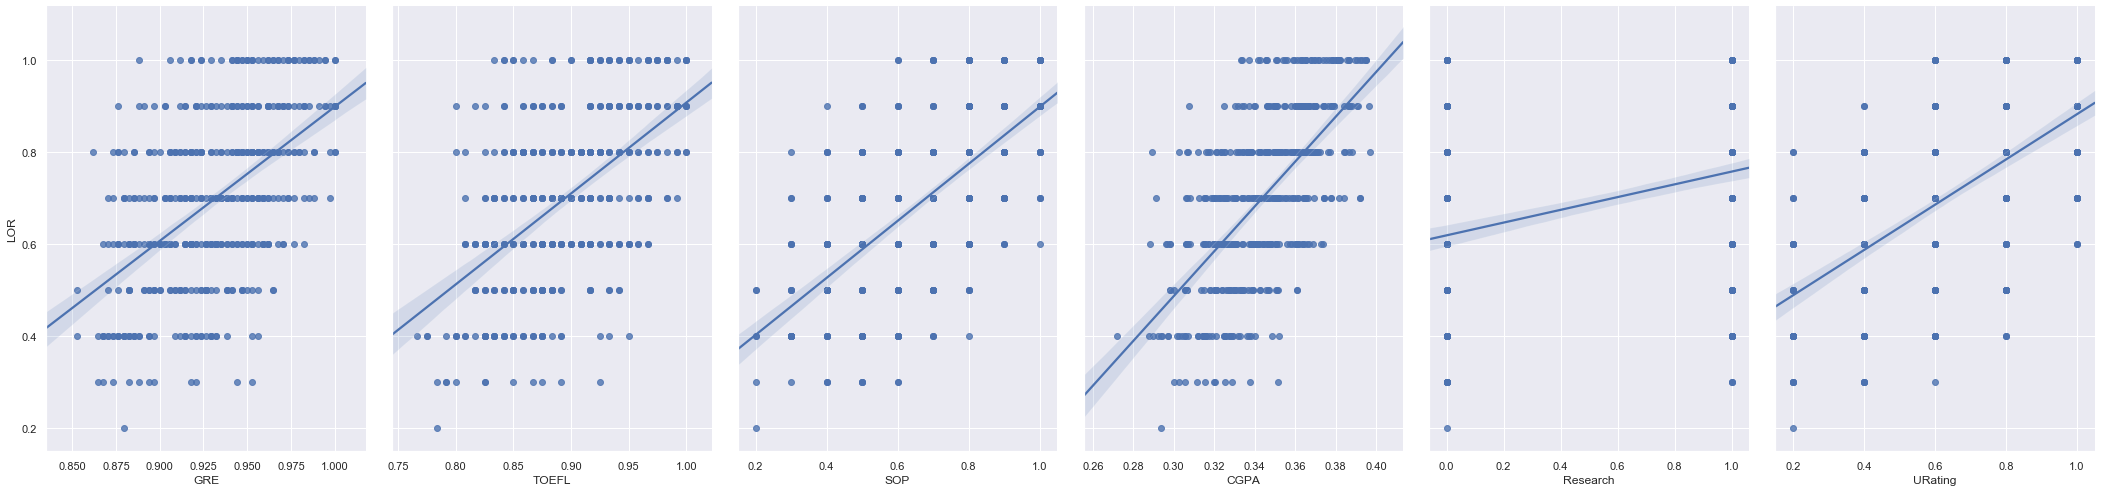

In [286]:
sns.pairplot(admit2, x_vars=['GRE','TOEFL','SOP','CGPA','Research','URating'], 
             y_vars='LOR', size=7, aspect=0.7, kind='reg')

#### Research

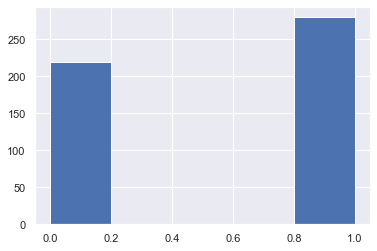

In [228]:
plt.hist(df.Research, bins=5);

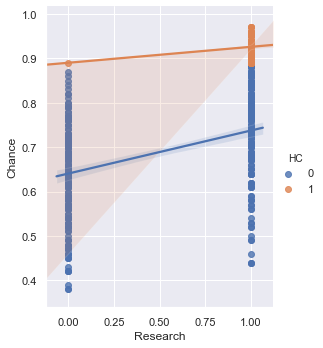

In [225]:
sns.pairplot(admit, x_vars=["Research"], y_vars=["Chance"],
             hue="HC", height=5, aspect=.8, kind="reg");

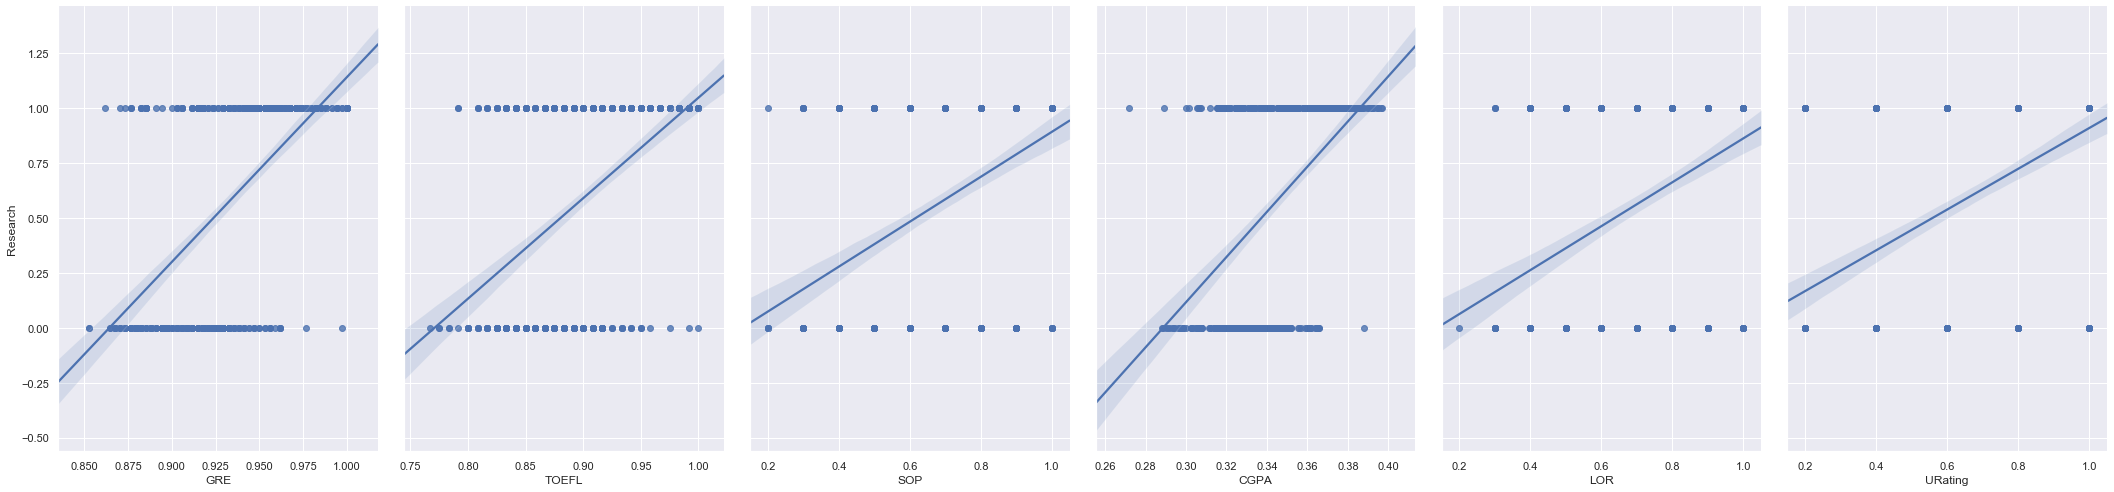

In [287]:
sns.pairplot(admit2, x_vars=['GRE','TOEFL','SOP','CGPA','LOR','URating'], 
             y_vars='Research', size=7, aspect=0.7, kind='reg')

#### University Rating

Distribution of the University Rating

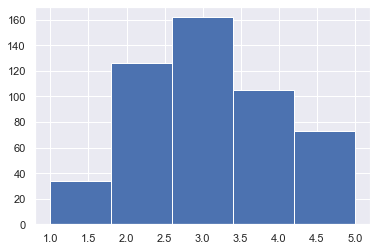

In [29]:
plt.hist(admit.URating, bins=5);

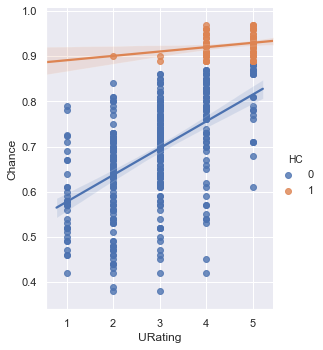

In [290]:
sns.pairplot(admit, x_vars=["URating"], y_vars=["Chance"],
             hue="HC", height=5, aspect=.8, kind="reg");

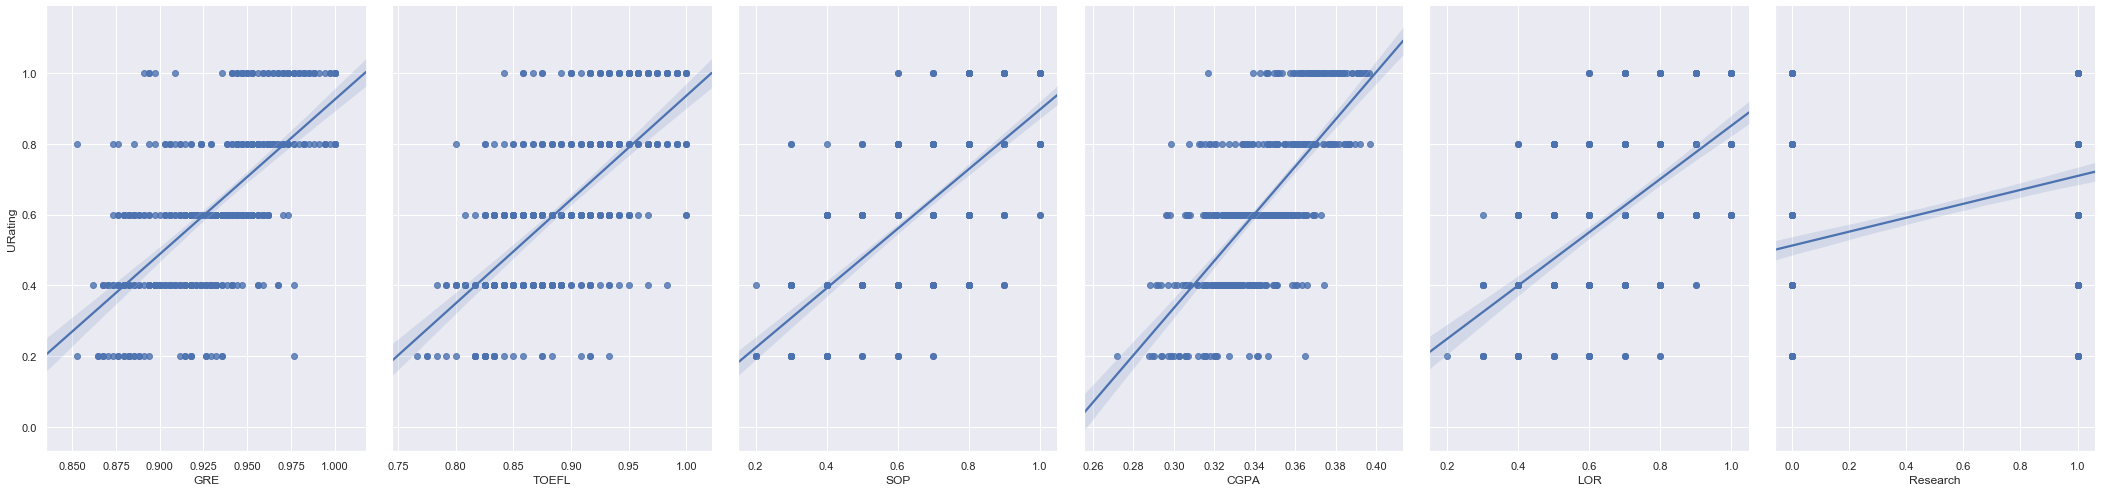

In [291]:
sns.pairplot(admit2, x_vars=['GRE','TOEFL','SOP','CGPA','LOR','Research'], 
             y_vars='URating', size=7, aspect=0.7, kind='reg')

### Cross-Correlation Map

A cross-correlation map can give us a high-level look at how each feature compares with each other

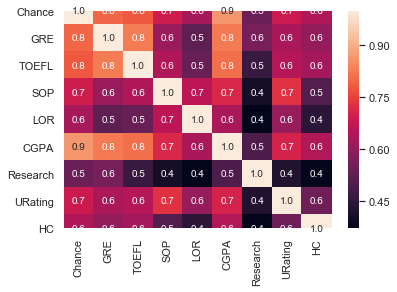

In [309]:
sns.heatmap(admit.corr(), annot = True, fmt = '.1f')

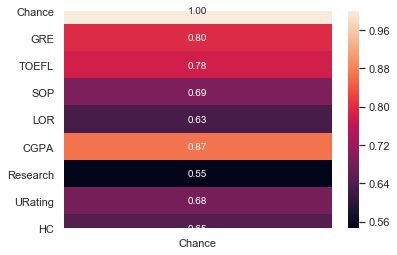

In [310]:
sns.heatmap(admit.corr()['Chance'].to_frame(), annot = True, fmt = '.2f')

## 4. Model, Training and Testing

### Linear regression

I use forward stepwise to find the model with highest squared R value.

In [347]:
#forwear_stepwise
def forward_stepwise(data_frame, factors,k):
    predictors=list.copy(factors)
    max_rsq=0
    cur_rsq=0
    idx=0
    
    selected=[]

    while(k>0):
        i=idx
        best_pdt_idx=0
        num_pdt=len(predictors)
        
        #->check all the predictors/column by column
        while(i<num_pdt):
            formula = "{} ~ {} + 1".format('Chance',' + '.join(selected + [predictors[i]]))
            cur_rsq = smf.ols(formula, data=data_frame).fit().rsquared_adj
            if cur_rsq > max_rsq:
                max_rsq=cur_rsq
                best_pdt_idx=i
                i=i+1
            else:
                i=i+1                                  
        selected.append(predictors[best_pdt_idx])
        predictors.remove(predictors[best_pdt_idx])
        k=k-1
        
    return(selected,max_rsq);

In [348]:
features=['GRE','TOEFL','CGPA','SOP','LOR','Research','URating']

In [349]:
r_list=[]
for i in range (len(features)):
    res=(forward_stepwise(admit,features,i))
    r_list.append(round(res[1],3))
    
res_idx=0
for i in range (1,len(r_list)):
    if r_list[i]>r_list[i-1]:
        res_idx=i+1
    i=i+1
print("the max r_square is obtained when there are",res_idx,"predictors")


the max r_square is obtained when there are 7 predictors


In [350]:
forward_stepwise(admit,features,7)

(['CGPA', 'GRE', 'LOR', 'Research', 'TOEFL', 'URating', 'SOP'],
 0.8131410966822366)

In [352]:
admit_model = smf.ols(formula='Chance~CGPA+GRE+LOR+Research+TOEFL+URating+SOP', data=admit).fit()
admit_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Chance   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     311.2
Date:                Sat, 14 Dec 2019   Prob (F-statistic):          3.36e-176
Time:                        16:24:23   Log-Likelihood:                 700.38
No. Observations:                 500   AIC:                            -1385.
Df Residuals:                     492   BIC:                            -1351.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1966      0.105    -11.450      0.000      -1.402      -0.991
CGPA           0.2945      0.024     12.113      0.000       0.247       0.342
GRE            0.0017      0.001      3.446      0.001       0.001       0.003
LOR            0.0152      0.004      3.657      0.000       0.007       0.023
Research       0.0233      0.007      3.518      0.000       0.010       0.036
TOEFL          0.0024      0.001      2.763      0.006       0.001       0.004
URating        0.0053      0.004      1.384      0.167      -0.002       0.013
SOP            0.0058      0.005      1.263      0.207      -0.003       0.015
==============================================================================
Omnibus:                       98.907   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.807
Skew:                          -0.985   Prob(JB):                     1.27e-55
Kurtosis:                       5.872   Cond. No.                     1.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Check if the model is a good fit.

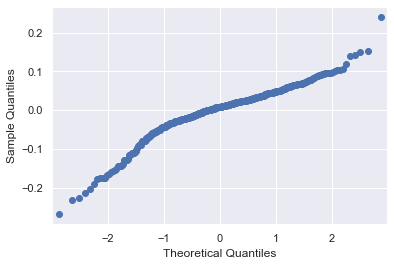

In [340]:
sm.qqplot(admit_model.resid);

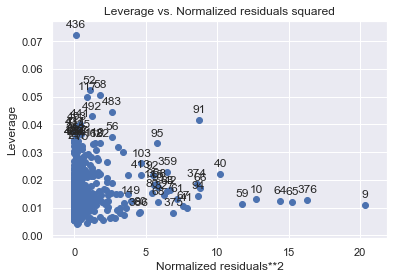

In [341]:
sm.graphics.plot_leverage_resid2(admit_model,alpha=0.5);

In [344]:
leverage_list_index=[52,436,58,56,95,91,40,59,10,64,65,376,9,374]
admit_new=admit.drop(leverage_list_index).reset_index(drop=True)
admit_model2 = smf.ols(formula='Chance~CGPA+GRE+LOR+Research+TOEFL+URating+SOP', data=admit_new).fit()
admit_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Chance   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     391.6
Date:                Sat, 14 Dec 2019   Prob (F-statistic):          2.00e-193
Time:                        16:22:52   Log-Likelihood:                 748.68
No. Observations:                 486   AIC:                            -1481.
Df Residuals:                     478   BIC:                            -1448.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2690      0.093    -13.617      0.000      -1.452      -1.086
CGPA           0.2784      0.023     12.204      0.000       0.234       0.323
GRE            0.0021      0.000      4.685      0.000       0.001       0.003
LOR            0.0142      0.004      3.880      0.000       0.007       0.021
Research       0.0175      0.006      2.966      0.003       0.006       0.029
TOEFL          0.0026      0.001      3.283      0.001       0.001       0.004
URating        0.0059      0.003      1.738      0.083      -0.001       0.013
SOP            0.0062      0.004      1.510      0.132      -0.002       0.014
==============================================================================
Omnibus:                       54.246   Durbin-Watson:                   0.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.360
Skew:                          -0.724   Prob(JB):                     1.07e-19
Kurtosis:                       4.489   Cond. No.                     1.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Classification

Here we will use logistic regression and k nearest neighborhood algorithms.  
First of all, we need to prepare the training and testing data.
We are not able to use the data above to do logistic regression algorithm directly since Y is a continuous variable.   
Therefore, we do some modification on the dataframe. If a candidate's chance of admit(Chance) is greater than 85% which is a relative high, the candidate will receive the 1 label. Otherwise, the candidate will receive the 0 label. We can look this data from HC(High chance) column.

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(admit.drop(['Chance','HC'],axis=1),
                                               admit['HC'],test_size=0.2,random_state=42)


### Logistic regression

In [360]:
lr=sklearn.linear_model.LogisticRegression() #with CV and without CV
lr_mod=lr.fit(X_train,Y_train.ravel());
lr_Y_pred=lr_mod.predict(X_test);
score=accuracy_score(Y_test.ravel(),lr_Y_pred.ravel());

lr_cm=sklearn.metrics.confusion_matrix(Y_test,lr_Y_pred)
lr_precision=lr_cm[1,1]/(lr_cm[0,1]+lr_cm[1,1])
lr_recall=lr_cm[1,1]/(lr_cm[1,0]+lr_cm[1,1])
lr_score=(lr_cm[0,0]+lr_cm[1,1])/(lr_cm[0,0]+lr_cm[1,1]+lr_cm[0,1]+lr_cm[1,0])

print('Accuracy score is ',lr_score)
print('Precision is', lr_precision)
print('Recall is', lr_recall)

print(sklearn.metrics.classification_report(Y_test,lr_Y_pred))

Accuracy score is  0.87
Precision is 0.7142857142857143
Recall is 0.5263157894736842
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        81
           1       0.71      0.53      0.61        19

    accuracy                           0.87       100
   macro avg       0.80      0.74      0.76       100
weighted avg       0.86      0.87      0.86       100



Prepare the data for ROC

In [361]:
Y_prob=lr_mod.predict_proba(X_test)
lr_fpr, lr_tpr, lr_threshold = roc_curve(Y_test,Y_prob[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)


In [42]:
#df is the input dataframe, factor is the features, n is the number of steps
features=['GRE','TOEFL','CGPA','SOP','LOR','Research','URating']
def find_best_model(df, factors,k):
    predictors=list.copy(factors)
    idx=0 
    selected=[]

    while(k>0):
        i=idx
        best_pdt_idx=0
        max_score=0
        cur_score=0
        num_pdt=len(predictors)
        #->check all the predictors/column by column
        while(i<num_pdt):
            #print('current features are:',selected+[predictors[i]])
            formula = "{} ~ {} + 1".format('C(HC,[[0],[1]])',' + '.join(selected + [predictors[i]]))
            #get the design matrices
            Y,X=patsy.dmatrices(formula,data=df)
            #make the training and testing data
            X_train75,X_test75,Y_train75,Y_test75=train_test_split(X,Y,test_size=0.2,random_state=42)
            #build a model and calculate the accuracy score of the mode
            cur_mod=lr.fit(X_train75,Y_train75.ravel());
            Y_predict75=cur_mod.predict(X_test75);
            cur_score=accuracy_score(Y_test75.ravel(),Y_predict75.ravel());
            print("The accuracy score for model with features",selected+[predictors[i]],"is",cur_score)
            if cur_score > max_score:
                max_score=cur_score
                #print("i=",i)
                best_pdt_idx=i
                i=i+1
            else:
                i=i+1
        print("***************************************************************************************************************")
        #print(predictors)
        #print(best_pdt_idx)
        selected.append(predictors[best_pdt_idx])
        predictors.remove(predictors[best_pdt_idx])
        print("When there are",len(selected),"features:")
        print("Greatest score is",max_score,"achieved when the features are",selected)
        print("***************************************************************************************************************")
        k=k-1
    
    return max_score

In [43]:
score_list=[]
for i in range (len(features)):
    res=find_best_model(admit,features,i+1)
    score_list.append(float(res))


The accuracy score for model with features ['GRE'] is 0.81
The accuracy score for model with features ['TOEFL'] is 0.81
The accuracy score for model with features ['CGPA'] is 0.81
The accuracy score for model with features ['SOP'] is 0.83
The accuracy score for model with features ['LOR'] is 0.81
The accuracy score for model with features ['Research'] is 0.81
The accuracy score for model with features ['URating'] is 0.86
***************************************************************************************************************
When there are 1 features:
Greatest score is 0.86 achieved when the features are ['URating']
***************************************************************************************************************
The accuracy score for model with features ['GRE'] is 0.81
The accuracy score for model with features ['TOEFL'] is 0.81
The accuracy score for model with features ['CGPA'] is 0.81
The accuracy score for model with features ['SOP'] is 0.83
The accuracy score 

In [44]:
res_idx=0
for i in range (1,len(score_list)):
    if score_list[i]>score_list[i-1]:
        score_idx=i+1
    i=i+1
print("The max accuracy score is acquired when there are",score_idx,"features.")

The max accuracy score is acquired when there are 5 features.


In [45]:
best_lr_features=['LOR','TOEFL','CGPA','Research']
lr_Y,lr_X=patsy.dmatrices('C(HC,[[0],[1]])~URating+Research+GRE+CGPA+TOEFL',data=admit)
bs_X_train,bs_X_test,bs_Y_train,bs_Y_test=train_test_split(lr_X,lr_Y,test_size=0.2,random_state=42)
bs_lr_mod=lr.fit(bs_X_train,bs_Y_train.ravel())
bs_Y_pred=bs_lr_mod.predict(bs_X_test);
#score=accuracy_score(bs_Y_test.ravel(),bs_Y_pred.ravel());
bs_lr_cm=sklearn.metrics.confusion_matrix(bs_Y_test,bs_Y_pred)
print('Logistic confusion matrix is =\n',bs_lr_cm)
print('Success=', bs_lr_cm[1,1]/(bs_lr_cm[1,0]+lr_cm[1,1]))
print(sklearn.metrics.classification_report(bs_Y_test,bs_Y_pred))

Logistic confusion matrix is =
 [[79  2]
 [ 9 10]]
Success= 0.5263157894736842
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.93        81
         1.0       0.83      0.53      0.65        19

    accuracy                           0.89       100
   macro avg       0.87      0.75      0.79       100
weighted avg       0.89      0.89      0.88       100



It seems the result is the same. Why?

### KNN

Use the K-Nearest Neighbors classification method to predict the if the students have high chance to be admitted and print out the prediction accuracy. Different k will have the different accuracy result.  
The first step is to find out the k that maximizes the accuracy.

In [46]:
def bestK_test(klist,X_train,Y_train,X_test,Y_test):
    score=0
    scores=[]
    for i in klist:
        knn = neighbors.KNeighborsClassifier(n_neighbors = i,weights='uniform' )
        ti_mod=knn.fit(X_train,Y_train.ravel())
        Y_pred=ti_mod.predict(X_test)
        kscore=accuracy_score(Y_pred.ravel(), Y_test.ravel()) 
        scores.append(kscore)
        if(kscore>score):
            score=kscore
            res=i 
    return scores

In [47]:
klist=np.arange(1,100)

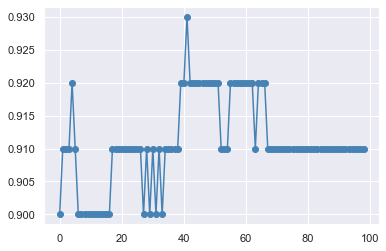

In [48]:
scores2=[]
scores2=bestK_test(klist,X_train,Y_train,X_test,Y_test)
#scores2[0]=np.mean(scores2)
plt.plot(scores2,'-ok',color='steelblue')

In [49]:
max_score_idx=np.argmax(scores2,axis=0)
print("the best knn model is found when k equals",max_score_idx,", with the accuracy score of",scores2[max_score_idx])

the best knn model is found when k equals 41 , with the accuracy score of 0.93


Now we get the best KNN model when k equals 41. 

In [364]:
k=41
knn_mod=sklearn.neighbors.KNeighborsClassifier(n_neighbors=9)
knn_mod.fit(X_train,Y_train)
Y_pred=knn_mod.predict(X_test)
knn_cm=sklearn.metrics.confusion_matrix(Y_test,Y_pred)
print('KNN(',k,') confusion matrix is =\n',knn_cm)
#print('Success=', knn_cm[1,1]/(knn_cm[1,0]+knn_cm[1,1]))
print(sklearn.metrics.classification_report(Y_test,Y_pred))

KNN( 41 ) confusion matrix is =
 [[79  2]
 [ 8 11]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        81
           1       0.85      0.58      0.69        19

    accuracy                           0.90       100
   macro avg       0.88      0.78      0.81       100
weighted avg       0.90      0.90      0.89       100



In [365]:
Y_prob=knn_mod.predict_proba(X_test)
knn_fpr, knn_tpr, knn_threshold = roc_curve(Y_test,Y_prob[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)


### LDA

In [366]:
lda=sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda_mod=lda.fit(X_train,Y_train)
Y_pred=lda_mod.predict(X_test)
lda_cm=sklearn.metrics.confusion_matrix(Y_test,Y_pred)
print('LDA confusion matrix is =\n',lda_cm)
print('Success=', lda_cm[1,1]/(lda_cm[1,0]+lda_cm[1,1]))
print(sklearn.metrics.classification_report(Y_test,Y_pred))

LDA confusion matrix is =
 [[80  1]
 [ 6 13]]
Success= 0.6842105263157895
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        81
           1       0.93      0.68      0.79        19

    accuracy                           0.93       100
   macro avg       0.93      0.84      0.87       100
weighted avg       0.93      0.93      0.93       100



In [367]:
Y_prob=lda_mod.predict_proba(X_test)
lda_fpr, lda_tpr, lda_threshold = roc_curve(Y_test,Y_prob[:,1])
lda_roc_auc = auc(lda_fpr, lda_tpr)


### QDA

In [368]:
qda=sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
qda_mod=qda.fit(X_train,Y_train)
Y_pred=qda_mod.predict(X_test)
qda_cm=sklearn.metrics.confusion_matrix(Y_test,Y_pred)
print('LDA confusion matrix is =\n',qda_cm)
print('Success=', qda_cm[1,1]/(qda_cm[1,0]+qda_cm[1,1]))
print(sklearn.metrics.classification_report(Y_test,Y_pred))

LDA confusion matrix is =
 [[80  1]
 [ 6 13]]
Success= 0.6842105263157895
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        81
           1       0.93      0.68      0.79        19

    accuracy                           0.93       100
   macro avg       0.93      0.84      0.87       100
weighted avg       0.93      0.93      0.93       100



In [55]:
Y_prob=qda_mod.predict_proba(X_test)
qda_fpr, qda_tpr, qda_threshold = roc_curve(Y_test,Y_prob[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)


### Decision Tree

In [373]:
tree_mod=sklearn.tree.DecisionTreeClassifier().fit(X_train,Y_train)
Y_pred=tree_mod.predict(X_test)
tree_cm=sklearn.metrics.confusion_matrix(Y_test,Y_pred)
print('Tree confusion matrix is = \n',tree_cm)
print('Success=', tree_cm[1,1]/(tree_cm[1,0]+tree_cm[1,1]))
print(sklearn.metrics.classification_report(Y_test,Y_pred))

In [374]:
Y_prob=tree_mod.predict_proba(X_test)
tree_fpr, tree_tpr, tree_threshold = roc_curve(Y_test,Y_prob[:,1])
tree_roc_auc = auc(tree_fpr, tree_tpr)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


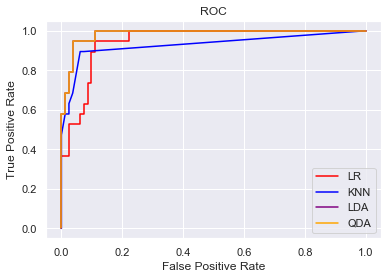

In [375]:
plt.title('ROC')
ax=plt.subplot(111)
plt.plot(lr_fpr, lr_tpr,color='red',label='LR')
plt.plot(knn_fpr, knn_tpr,color='blue',label='KNN')
plt.plot(lda_fpr, lda_tpr,color='purple',label='LDA')
plt.plot(qda_fpr, qda_tpr,color='orange',label='QDA')
#plt.plot(tree_fpr, tree_tpr,color='green',label='TREE')
ax.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion

All the features are positively related to the response variable.   
A student who has higher possibility to be admitted(89% chance of admit) will have following features:  
GRE > 320  
TOEFL > 110  
GPA > 3.5  
Statement of Purpose > 3.5  
Letters of recommendation > 3  
University Rating > 2  
Have research experience  
  
The best model to predict the admission can be got using the LDA algorithm.  
